## Notebook for understanding the pro-svd pipeline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from proSVD import proSVD
from pro_utils import get_streamingSVD
from pathlib import Path
from scipy.io import loadmat
from tqdm import tqdm

In [ ]:
mat = loadmat("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt2.mat")
mat = mat['data']

print(type(mat))        # <class 'numpy.ndarray'>
print(mat.dtype.names)

In [ ]:
data_struct = mat[0, 0]  # MATLAB structs are 2D arrays even if 1x1
data = {field: data_struct[field] for field in mat.dtype.names}

In [ ]:
data.keys()

# Get single-reach control trials

In [ ]:
# get no laser trials
control_idxs = np.where(data["pattern_id"][:150] == 0)[0] 

In [ ]:
# get blank pattern trials
#b = np.where(data["pattern_id"][:150] == 2)[0]

In [ ]:
#control_idxs = np.sort(np.concatenate((a, b)))
control_idxs

### Only want to look at single reach trials

In [ ]:
single_idxs = np.where(data["single"] == 1)[1]
single_idxs

In [ ]:
control_idxs = np.intersect1d(control_idxs, single_idxs)
control_idxs

In [ ]:
control_idxs.shape

## Get relevant time information

In [ ]:
cue_times = data["cue_rec_time"][:, :150]
cue_times[:, control_idxs]

In [ ]:
lift_times = data["lift_ms"][:, :150]
lift_times[:, control_idxs]

In [ ]:
mouth_times = data["mouth_ms"][:, :150]
mouth_times[:, control_idxs]

## Get the AP.bin file

In [ ]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [ ]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [ ]:
meta_data = get_meta(meta_path)

In [ ]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

## Get conversion params

In [ ]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [ ]:
vmax

In [ ]:
imax

In [ ]:
gain

## Get first trial

#### 50ms before "lift" to 300ms after behavior

In [ ]:
trial_no = 0

In [ ]:
# get the lift time in ap units 
# cue + lift time (ms) / 1000 = s * 30_000 (sR) 
lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
lift_time

# get end of behavior = mouth (260ms) + 300ms 
end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260 + 300) / 1_000 * 30_000)
(lift_time, end_behavior)

In [ ]:
trial_one = ap_data[:150, lift_time:end_behavior]
trial_one.shape

## Convert to microvolts 

In [ ]:
conv_data = 1e6 * trial_one / vmax / imax / gain

In [ ]:
conv_data.shape

## Filter

In [ ]:
from real_spike.utils import butter_filter

In [ ]:
filt_data = butter_filter(conv_data, 1_000, 30_000)
filt_data.shape

## Median/MAD Threshold 

In [ ]:
from real_spike.utils import get_spike_events

In [ ]:
median = np.median(filt_data, axis=1)
median.shape

In [ ]:
spike_ixs, counts = get_spike_events(filt_data, median)

In [ ]:
# create a range of the entire trial time
# binarize the spike times
# bin into 5ms bins (every 150 data points) 

In [ ]:
a = np.zeros((filt_data.shape[0], filt_data.shape[1]))

In [ ]:
for i, sc in enumerate(spike_ixs):
    a[i, sc] = 1

## Bin the spike data

In [ ]:
def bin_spike_data(spikes, bin_size):
    n_channels, n_timepoints = spikes.shape
    n_bins = n_timepoints // bin_size  # drop remainder
 #   print(n_bins)
    spikes = spikes[:, :n_bins * bin_size]  # truncate to fit bins

    # Reshape and sum
    binned = spikes.reshape(n_channels, n_bins, bin_size).sum(axis=2)
    return binned

In [ ]:
bin_size = 20 # 10ms * 30 points per 1ms

In [ ]:
b = bin_size * 30
binned_spikes = bin_spike_data(a, bin_size=b)

In [ ]:
binned_spikes.shape

## Apply kalman filter

In [ ]:
import numpy as np
from filterpy.kalman import KalmanFilter

def apply_kalman_filter(data, A=1, H=1, Q=1e-2, R=1, initial_state=None):
    """
    Applies 1D Kalman filter to each channel in the binned spike data.

    Args:
        data (ndarray): Shape (n_channels, n_time_bins)
        A: State transition
        H: Observation model
        Q: Process noise
        R: Measurement noise
        initial_state: Optional starting value per channel

    Returns:
        ndarray: Smoothed data of same shape
    """
    n_channels, n_time = data.shape
    smoothed = np.zeros_like(data, dtype=float)

    for ch in range(n_channels):
        kf = KalmanFilter(dim_x=1, dim_z=1)
        kf.F = np.array([[A]])     # State transition matrix
        kf.H = np.array([[H]])     # Observation matrix
        kf.Q = np.array([[Q]])     # Process noise covariance
        kf.R = np.array([[R]])     # Measurement noise covariance
        kf.x = np.array([[initial_state[ch] if initial_state else data[ch, 0]]])  # Initial state
        kf.P = np.eye(1) * 1       # Initial covariance

        for t in range(n_time):
            kf.predict()
            kf.update(np.array([[data[ch, t]]]))
            smoothed[ch, t] = kf.x[0, 0]

    return smoothed

In [ ]:
#binned = np.random.poisson(0.5, (4, 100))  # fake binned data
smoothed = apply_kalman_filter(binned_spikes)


In [ ]:
import matplotlib.pyplot as plt

plt.plot(binned_spikes[0], label='Original')
plt.plot(smoothed[0], label='Kalman Smoothed')
plt.legend()
plt.title('Channel 0')
plt.xlabel('Time Bin')
plt.ylabel('Spike Count')
plt.show()


In [ ]:
all_data = list()
#explained_variances = list()

# HYPERPARAMETERS TO TOGGLE
bin_size = 40
Q=1e-3

for i in tqdm(control_idxs):
    trial_no = i
    # get time points in ap space
    lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
    
    # get end of behavior = mouth (260ms) + 300ms 
    end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260 + 300) / 1_000 * 30_000)
    #print(lift_time, end_behavior)

    trial = ap_data[:150, lift_time:end_behavior]

    conv_data = 1e6 * trial / vmax / imax / gain

    filt_data = butter_filter(conv_data, 1_000, 30_000)

    median = np.median(filt_data, axis=1)

    spike_ixs, counts = get_spike_events(filt_data, median)
    
    a = np.zeros((filt_data.shape[0], filt_data.shape[1]))

    for i, sc in enumerate(spike_ixs):
        a[i, sc] = 1

    b = bin_size * 30 # 30ms per bin
    binned_spikes = bin_spike_data(a, b)

    smoothed = apply_kalman_filter(binned_spikes, Q=Q)

    all_data.append(smoothed)

In [ ]:
d = np.concatenate(all_data, axis=1)

In [ ]:
d.shape

In [ ]:
k = 6  # reduced dim
l = 10    # num cols processed per iter
decay = 1 # 'forgetting' to track nonstationarity. 1 = no forgetting
l1 = 20   # num cols init
num_iters = 2#np.floor((smoothed.shape[1] - l1) / l).astype('int') 
update_times = np.arange(1, num_iters) 

num_iters

In [ ]:
A_init = d[:, :l1]
pro = proSVD(k, history=num_iters, trueSVD=True)
pro.initialize(A_init)

In [ ]:
pro.run(d, [l1])

# u, s, v = np.linalg.svd(data, full_matrices=False)
# u = u[:, :k]
# basis = pro.Q
# res1 = np.linalg.norm(basis - u @ u.T @ basis)
# res2 = np.linalg.norm(u - basis @ basis.T @ u)

# print(res1, res2)

# fig, ax = plt.subplots() 
# ax.plot(derivs.T)

In [ ]:
u, s, v = np.linalg.svd(d, full_matrices=False)
u = u[:, :k]
basis = pro.Q
res1 = np.linalg.norm(basis - u @ u.T @ basis)
res2 = np.linalg.norm(u - basis @ basis.T @ u)

print(res1, res2)

fig, ax = plt.subplots() 
ax.plot(derivs.T)

In [ ]:
dists = np.linalg.norm(pro.Qs - pro.Q[:, :, np.newaxis], axis=0)
t = derivs.shape[1]

fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].plot(derivs[:, :t].T)
ax[0].legend(labels=['vec{}'.format(i) for i in range(k)])
ax[0].set(title='derivatives of proSVD basis vectors', 
          xlabel='bins seen', ylabel='1st difference of basis vectors')

for j in range(2):
    ax[j+1].plot(frac_vars[j][:, :t].T)
    ax[j+1].plot(frac_vars[j].sum(axis=0)[:t], ls='--', color='k', alpha=0.5)
    ax[j+1].set(title='variance explained by each vector', 
            xlabel='bins seen', ylabel='fraction of variance explained')

ax[2].plot(frac_vars[0].sum(axis=0)[:t], ls=':', color='k', alpha=0.5)

In [ ]:
Us, Ss = get_streamingSVD(d, k, l1, l, 2, window=False)

#%% looking at stuff
vals = (Ss[:6, :]**2) / (Ss[:, :]**2).sum(axis=0)
fig, ax = plt.subplots()
for i in range(2):
    ax.plot(frac_vars[i].sum(axis=0)[:t])
ax.plot(vals.sum(axis=0), ls='--', color='k')
ax.set(xlabel='bins seen', ylabel='fraction of variance explained')
ax.legend(labels=['Q', 'U - pro', 'U - dumb streaming'])


In [ ]:
proj = pro.Q.T @ all_data[0]

In [ ]:
proj.shape

In [ ]:
for d in all_data:
    proj = pro.Q.T @ d
    plt.plot(proj[:, 0], proj[:, 1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Projected trajectories using proSVD')

In [ ]:
dists = np.linalg.norm(pro.Qs - pro.Q[:, :, np.newaxis], axis=0)
t = derivs.shape[1]

fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].plot(derivs[:, :t].T)
ax[0].legend(labels=['vec{}'.format(i) for i in range(k)])
ax[0].set(title='derivatives of proSVD basis vectors', 
          xlabel='bins seen', ylabel='1st difference of basis vectors')

for j in range(2):
    ax[j+1].plot(frac_vars[j][:, :t].T)
    ax[j+1].plot(frac_vars[j].sum(axis=0)[:t], ls='--', color='k', alpha=0.5)
    ax[j+1].set(title='variance explained by each vector', 
            xlabel='bins seen', ylabel='fraction of variance explained')

ax[2].plot(frac_vars[0].sum(axis=0)[:t], ls=':', color='k', alpha=0.5)


fig, ax = plt.subplots()
labels = ['sv{}'.format(i+1) for i in range(pro.Ss.shape[0])]
ax.plot(pro.Ss.T)
direction_change = np.cumsum(3 * 3)
for i in direction_change:
    ax.axvline(i, ls='--', color='k', alpha=0.4)
ax.set(xlabel='bin (15 ms bins)', ylabel='singular value')
ax.legend(labels)

# also change in svs
Ss_deriv = pro.Ss[:, 1:] - pro.Ss[:, :-1]
fig, axs = plt.subplots(2, 3, figsize=(12,7), sharex=True, sharey=True)
t = 0
for i in range(2):
    for j in range(3):
        axs[i, j].plot(Ss_deriv[i, :], color='C{}'.format(t))
        for k in direction_change:
            axs[i,j].axvline(k, ls='--', color='k', alpha=0.4)
        t += 1
        axs[i,j].set(ylim=(-.05, 1), title='sv{}'.format(t),
                     xlabel='bin (15 ms)', ylabel='change in singular value')

#trial markers
# for currax in [ax1, ax2]:
#     currax.set(xlim=(-50, 5000))
#     for i in np.arange(0, spikes.shape[1], reduced_bins):
#         currax.axvline(i, ls='--', color='grey', alpha=.4)

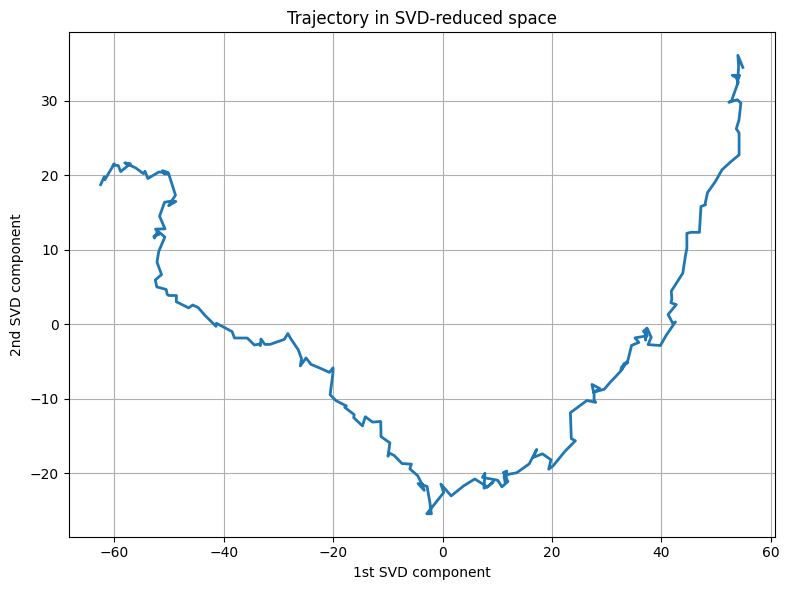

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Example: synthetic data (T timepoints x N features)
T, N = 200, 50
np.random.seed(0)
X = np.cumsum(np.random.randn(T, N), axis=0)  # simulated random walk

# Step 1: center the data
X_centered = X - X.mean(axis=0)

# Step 2: perform SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

# Step 3: project data onto top components (trajectories)
# Each column in U*S is a trajectory along one principal direction
proj = U @ np.diag(S)  # shape: T x N

# Step 4: plot top 2D trajectory
plt.figure(figsize=(8, 6))
plt.plot(proj[:, 0], proj[:, 1], lw=2)
plt.xlabel('1st SVD component')
plt.ylabel('2nd SVD component')
plt.title('Trajectory in SVD-reduced space')
plt.grid(True)
plt.tight_layout()
plt.show()